In [1]:
#подключение всех нужных библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path

# импортирование из sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score, 
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

# Зафиксируем random state
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
# Зафиксиурем n_init
N_INIT = 10

# Зафиксируем путь
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print("Artifacts dir:", ARTIFACTS_DIR.resolve())

Artifacts dir: D:\_Programming\VS_Code\mirea-dpo-aie\homeworks\HW07\artifacts


In [2]:
# Массивы для сохранения результатов
best_configs = []
metrics_summery=[]


# Функции для подсчета метрик и визуализации
def safe_cluster_metrics(X, labels):
    """Считает метрики; возвращает None, если метрика неприменима."""
    unique = np.unique(labels)
    # Нужно минимум 2 кластера
    if len(unique) < 2:
        return None

    # silhouette требует, чтобы все кластеры имели >1 точки (часто, но не всегда)
    # В sklearn silhouette_score может падать, если какой-то кластер пуст/особый.
    try:
        sil = float(silhouette_score(X, labels))
    except Exception:
        sil = None

    try:
        db = float(davies_bouldin_score(X, labels))
    except Exception:
        db = None

    try:
        ch = float(calinski_harabasz_score(X, labels))
    except Exception:
        ch = None

    return {"silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch}

def pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE):
    """PCA(2D) именно для визуализации."""
    p = PCA(n_components=2, random_state=random_state)
    return p.fit_transform(X_scaled)

def plot_2d_embedding(emb2d, labels, title,file_name=None):
    plt.figure(figsize=(7, 5))
    plt.scatter(emb2d[:, 0], emb2d[:, 1], c=labels, s=18)
    plt.title(title)
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    if file_name!=None:
        plt.savefig(ARTIFACTS_DIR / f"figures/{file_name}.png")
    plt.show()

def summarize_labels(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique.tolist(), counts.tolist()))

## Загрузка данных и первичный анализ

In [3]:
# Загрузим датасеты и выведем первые несколько строк
df_01 = pd.read_csv("data/S07-hw-dataset-01.csv")
df_02 = pd.read_csv("data/S07-hw-dataset-02.csv")
df_03 = pd.read_csv("data/S07-hw-dataset-03.csv")
display(df_01.head(),df_02.head(),df_03.head())


,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899


In [4]:
# Выведем информацию по датасетам
df_01.info()
print("==============================")
df_02.info()
print("==============================")
df_03.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB
<c

In [5]:
# Выведес статистику по датасетам
display(df_01.describe(),df_02.describe(),df_03.describe())

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745


,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076


,sample_id,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.246296,1.033764,0.212776,-0.027067
std,4330.271354,4.592421,4.710791,1.530017,2.506375
min,0.000000,-9.995585,-9.980853,-5.212038,-8.785884
25%,3749.750000,-1.782144,-2.666393,-0.966224,-1.731128
50%,7499.500000,0.664226,1.831257,0.296508,-0.052391
75%,11249.250000,4.435671,4.969630,1.390273,1.673831
max,14999.000000,16.207863,14.271153,5.795876,11.266865


In [6]:
# Проверка на пропуски и типы признаков
data=[df_01,df_02,df_03]
n=1
for df in data:
    print(f"Количество пропусков в df_0{n}: {df.isna().sum().sum()}")
    print(f"Типы данны признаков в df_0{n}: {df.dtypes.unique()} \n")
    n+=1

Количество пропусков в df_01: 0
Типы данны признаков в df_01: [dtype('int64') dtype('float64')] 

Количество пропусков в df_02: 0
Типы данны признаков в df_02: [dtype('int64') dtype('float64')] 

Количество пропусков в df_03: 0
Типы данны признаков в df_03: [dtype('int64') dtype('float64')] 



### Итог первичного анализа
В датасетах нет пропусков и все признаки имеют числовой тип

In [7]:
# Выделим признаки для каждого датафрейма
X_01 = df_01.iloc[:,1:]
X_02 = df_02.iloc[:,1:]
X_03 = df_03.iloc[:,1:]

# Также сохраним sample_id
sample_id_01 = df_01.iloc[:,0]
sample_id_02 = df_02.iloc[:,0]
sample_id_03 = df_03.iloc[:,0]

## Препроцессинг

In [8]:
# Отмасштабируем признаки
scaler = StandardScaler()
X_01_scaled = scaler.fit_transform(X_01)
X_02_scaled = scaler.fit_transform(X_02)
X_03_scaled = scaler.fit_transform(X_03)

## Модели

In [9]:
# Диапазон K для KMeans
kmeans_ks = list(range(2, 21))

# Сетка для DBSCAN: eps и min_samples
dbscan_eps = [0.5, 0.8, 1.5, 2.0, 2.5, 3.0, 3.5]
dbscan_min_samples = [3, 5, 10]

# Agglomerative: число кластеров и linkage (для sklearn Agglomerative: 'ward' требует euclidean)
agg_ks = list(range(2, 21))
agg_linkages = ["ward", "complete", "average"]

# Функция для оценки KMeans
def eval_kmeans_grid(X_feat, ks, random_state=RANDOM_STATE):
    results = []
    for k in ks:
        model = KMeans(n_clusters=k, random_state=random_state, n_init=N_INIT)

        labels = model.fit_predict(X_feat)
        metrics = safe_cluster_metrics(X_feat, labels)

        results.append({
            "algo": "kmeans",
            "params": {"k": k},
            "labels": labels,
            "metrics": metrics,
            "inertia": float(model.inertia_),
            "n_clusters": len(np.unique(labels)),
            "noise_frac": 0.0,
        })
    return results

# Построение графика k vs выбранная метрика
def kmeans_plot_metrics(kmeans_results,metric="silhouette",label=None):
# Быстрый график метрики по k
    ks = [r["params"]["k"] for r in kmeans_results]
    sil = [r["metrics"][metric] if r["metrics"] else None for r in kmeans_results]

    plt.figure(figsize=(7, 4))
    plt.plot(ks, sil, marker="o")
    plt.title(f"KMeans: {metric} vs k")
    plt.xlabel("k")
    plt.ylabel(metric)
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    if label!=None:
        plt.savefig(ARTIFACTS_DIR / f"figures/{label}_kmeans_{metric}VSk.png")
    plt.show()

# Построение графика k vs inertia
def kmeans_plot_inertia(kmeans_results,label=None):
    # Инерция (elbow) – как эвристика
    ks = [r["params"]["k"] for r in kmeans_results]
    inertia = [r["inertia"] for r in kmeans_results]
    plt.figure(figsize=(7, 4))
    plt.plot(ks, inertia, marker="o")
    plt.title("KMeans: inertia vs k (elbow heuristic)")
    plt.xlabel("k")
    plt.ylabel("inertia")
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    if label!=None:
        plt.savefig(ARTIFACTS_DIR / f"figures/{label}_kmeans_inertiaVSk.png")
    plt.show()

# Выбор лучшего значения по метрике
def pick_best(results,metric="silhouette"):
    if metric !="davies_bouldin":
        best = None
        best_score = -np.inf
        for r in results:
            m = r["metrics"]
            if m is None:
                continue
            s = m[metric]
            if s is None:
                continue
            if s > best_score:
                best_score = s
                best = r
        return best, best_score
    else:
        best = None
        best_score = np.inf
        for r in results:
            m = r["metrics"]
            if m is None:
                continue
            s = m[metric]
            if s is None:
                continue
            if s < best_score:
                best_score = s
                best = r
        return best, best_score

# Функция для оценки DBSCAN
def eval_dbscan_grid(X_feat, eps_list, min_samples_list):
    results = []
    n = len(X_feat)

    for eps in eps_list:
        for ms in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=ms)
            labels = model.fit_predict(X_feat)

            noise_frac = float(np.mean(labels == -1))
            # Метрики по non-noise
            mask = labels != -1
            labels_nn = labels[mask]
            X_nn = X_feat[mask]

            # Перенумеруем метки non-noise, чтобы метрики работали корректнее (не обязательно, но аккуратно)
            if len(labels_nn) > 0:
                uniq = np.unique(labels_nn)
                mapping = {u: i for i, u in enumerate(uniq)}
                labels_nn = np.array([mapping[v] for v in labels_nn], dtype=int)

            metrics = None
            n_clusters = 0
            if len(X_nn) >= 10 and len(np.unique(labels_nn)) >= 2:
                metrics = safe_cluster_metrics(X_nn, labels_nn)
                n_clusters = len(np.unique(labels_nn))

            results.append({
                "algo": "dbscan",
                "params": {"eps": float(eps), "min_samples": int(ms)},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": int(n_clusters),
                "noise_frac": float(noise_frac),
                "n_non_noise": int(mask.sum()),
            })
    return results


def eval_agglomerative_grid(X_feat, ks, linkages):
    results = []
    for linkage_name in linkages:
        for k in ks:
            try:
                model = AgglomerativeClustering(n_clusters=k, linkage=linkage_name)
                labels = model.fit_predict(X_feat)
            except Exception:
                continue

            metrics = safe_cluster_metrics(X_feat, labels)

            results.append({
                "algo": "agglomerative",
                "params": {"k": int(k), "linkage": linkage_name},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": len(np.unique(labels)),
                "noise_frac": 0.0,
            })
    return results

### Датасет 01

#### Метод 1: Kmeans

In [10]:
# Посчитаем результаты для разных значений k для метода kmeans
kmeans_results_01 = eval_kmeans_grid(X_01_scaled,kmeans_ks)


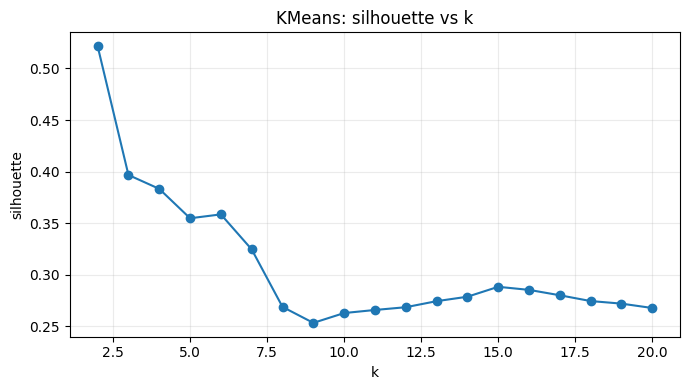

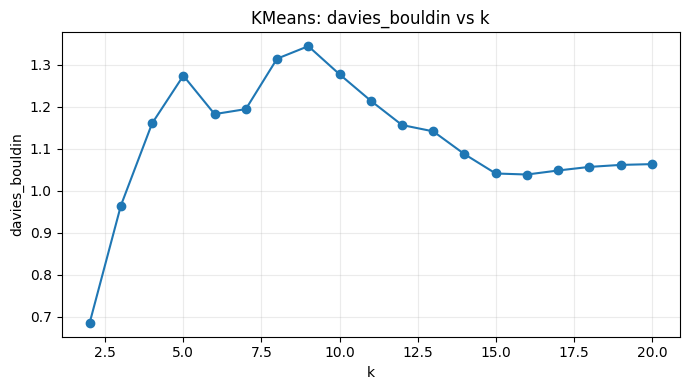

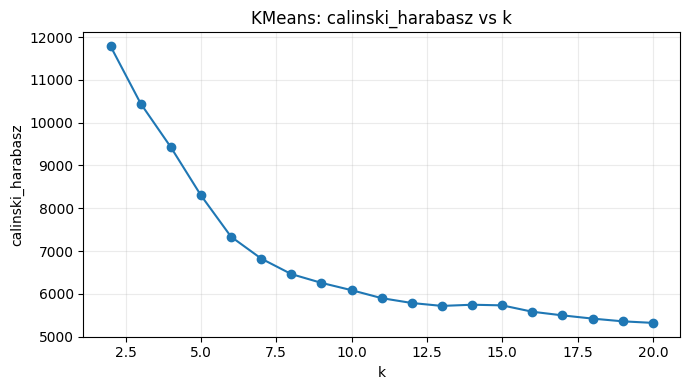

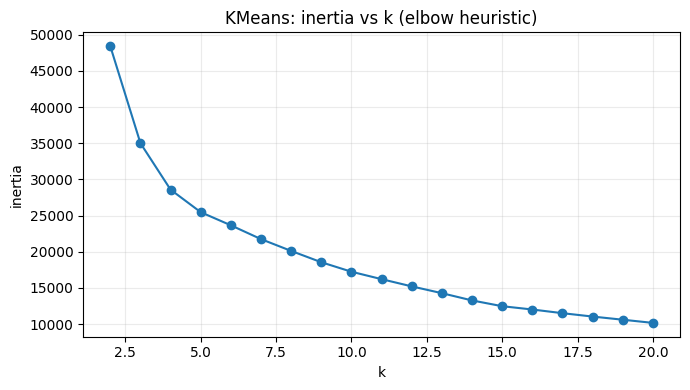

In [11]:
# Построим графики
kmeans_plot_metrics(kmeans_results_01,"silhouette","ds-01")
kmeans_plot_metrics(kmeans_results_01,"davies_bouldin","ds-01")
kmeans_plot_metrics(kmeans_results_01, "calinski_harabasz","ds-01")
kmeans_plot_inertia(kmeans_results_01,"df-01")

In [12]:
# Выберем лучшую модель по силуэту
best_kmeans_01, best_kmeans_s_01 = pick_best(kmeans_results_01,"silhouette")
best_kmeans_01["params"], round(best_kmeans_s_01, 3), best_kmeans_01["metrics"]
 

({'k': 2},
 0.522,
 {'silhouette': 0.5216395622404242,
  'davies_bouldin': 0.6853295219054459,
  'calinski_harabasz': 11786.95462267153})

#### Метод 2: DBSCAN

In [13]:
# Посчитаем результаты для разных значений min_samples и eps для метода DBSCAN
dbscan_results_01 = eval_dbscan_grid(X_01_scaled,dbscan_eps,dbscan_min_samples)

In [14]:
print(len(dbscan_results_01))
# Посмотрим, какие варианты вообще дали >=2 кластера (без шума) и посчитали silhouette
valid = [r for r in dbscan_results_01 if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid))

# Сортировка по silhouette
valid_sorted_01 = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted_01[:8]:
    print(r["params"], 
          "sil=", round(r["metrics"]["silhouette"], 3),
          "dav_boul=", round(r["metrics"]["davies_bouldin"], 3),
          "cal_har=", round(r["metrics"]["calinski_harabasz"], 3),
           "noise=", round(r["noise_frac"], 3),
             "clusters=", r["n_clusters"])

best_dbscan_01 = valid_sorted_01[0] if valid_sorted_01 else None
print("Лучшие параметры: ",best_dbscan_01["params"] if best_dbscan_01 else "No valid config found")
print("Доля шума в лучшем варианте: ",best_dbscan_01["noise_frac"])

21
Valid DBSCAN configs: 15
{'eps': 2.0, 'min_samples': 3} sil= 0.522 dav_boul= 0.685 cal_har= 11786.955 noise= 0.0 clusters= 2
{'eps': 2.0, 'min_samples': 5} sil= 0.522 dav_boul= 0.685 cal_har= 11786.955 noise= 0.0 clusters= 2
{'eps': 2.0, 'min_samples': 10} sil= 0.522 dav_boul= 0.685 cal_har= 11786.955 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 3} sil= 0.522 dav_boul= 0.685 cal_har= 11786.955 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 5} sil= 0.522 dav_boul= 0.685 cal_har= 11786.955 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 10} sil= 0.522 dav_boul= 0.685 cal_har= 11786.955 noise= 0.0 clusters= 2
{'eps': 1.5, 'min_samples': 3} sil= 0.397 dav_boul= 0.964 cal_har= 10446.598 noise= 0.0 clusters= 3
{'eps': 1.5, 'min_samples': 5} sil= 0.397 dav_boul= 0.964 cal_har= 10446.598 noise= 0.0 clusters= 3
Лучшие параметры:  {'eps': 2.0, 'min_samples': 3}
Доля шума в лучшем варианте:  0.0


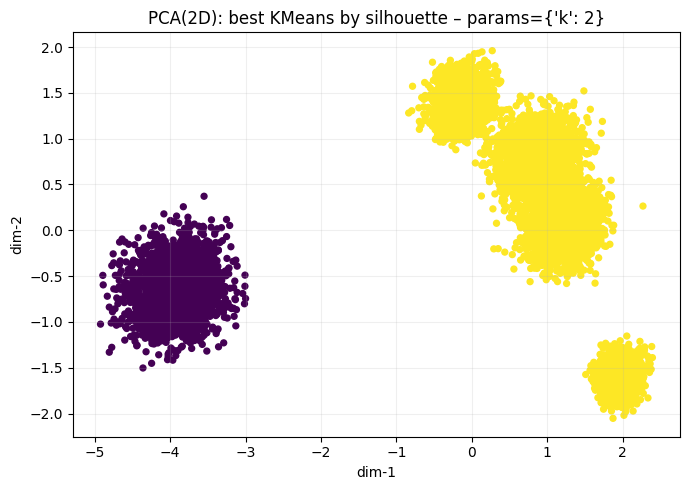

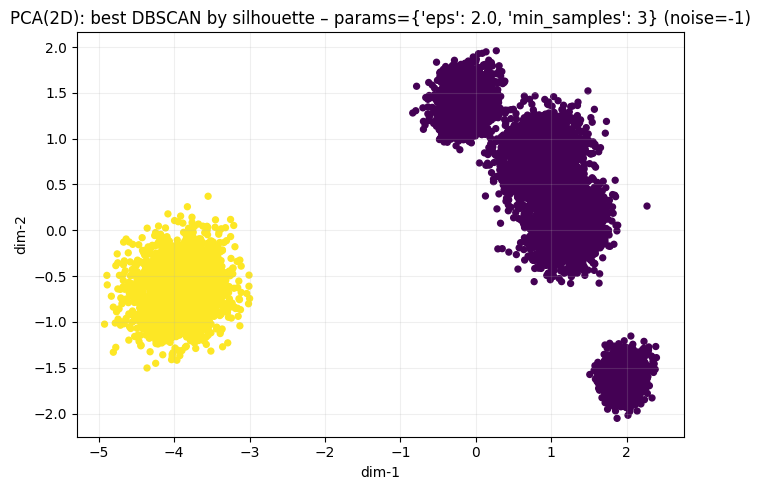

In [15]:
X_plot2d_01 = pca_2d_for_plot(X_01_scaled, random_state=RANDOM_STATE)

# KMeans best
plot_2d_embedding(
    X_plot2d_01, best_kmeans_01["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans_01['params']}",
    file_name="ds-01_kmeans_PCA(2D)"
)

# DBSCAN best (if exists)
if best_dbscan_01 is not None:
    plot_2d_embedding(
        X_plot2d_01, best_dbscan_01["labels"],
        title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan_01['params']} (noise=-1)",
        file_name="ds-01_dbscan_PCA(2D)"
    )

#### Итог
----
Kmeans и DBSCAN показали примерно одинаковые результаты.  
В обоих случаях лучшие метрики алгоритмы показали при разбиении данных на 2 кластера.  
Лучшим будем считать метод kmeans: k=2  
Метрики:  
'silhouette': 0.5216395622404242,  
'davies_bouldin': 0.6853295219054459,  
'calinski_harabasz': 11786.95462267153  
Схожесть результатов двух методов свидительствуют о том, что кластеры шарообразной формы с примерно одинаковой плотностью   

In [ ]:
# Сохраним результаты
metrics_summery.append({"dataset":"S07-hw-dataset-01.csv","kmeans_results":kmeans_results_01,"dbscan_results":dbscan_results_01})
best_configs.append({"dataset":"S07-hw-dataset-01.csv","method":best_kmeans_01["algo"],"parametrs":best_kmeans_01["params"],"criteria":"silhouette_score"})
labels_hw07_ds1 = pd.DataFrame({
    'sample_id': sample_id_01.values,
    'cluster_label': best_kmeans_01["labels"]      
})
labels_hw07_ds1.to_csv(ARTIFACTS_DIR / "labels/labels_hw07_ds1.csv")

#### Проверка устойчивости

In [17]:
# Функция для вывода ARI и NMI
def external_metrics(y_true, labels):
    return {
        "ARI": float(adjusted_rand_score(y_true, labels)),
        "NMI": float(normalized_mutual_info_score(y_true, labels)),
    }

comparing_with=best_kmeans_01["labels"] 
random_states = [52,69,228,420,1337]
for state in random_states:
    print(f"Comparing with random state: {state}")
    kmeans_results_rand = eval_kmeans_grid(X_01_scaled,kmeans_ks,state)
    best_kmeans_rand, best_kmeans_s_rand = pick_best(kmeans_results_rand,"silhouette")
    print(best_kmeans_rand["params"], round(best_kmeans_s_rand, 3), best_kmeans_rand["metrics"])
    print(external_metrics(comparing_with,best_kmeans_rand["labels"]))
    print("="*42)



Comparing with random state: 52
{'k': 2} 0.522 {'silhouette': 0.5216395622404242, 'davies_bouldin': 0.6853295219054459, 'calinski_harabasz': 11786.95462267153}
{'ARI': 1.0, 'NMI': 1.0}
Comparing with random state: 69
{'k': 2} 0.522 {'silhouette': 0.5216395622404242, 'davies_bouldin': 0.6853295219054459, 'calinski_harabasz': 11786.95462267153}
{'ARI': 1.0, 'NMI': 1.0}
Comparing with random state: 228
{'k': 2} 0.522 {'silhouette': 0.5216395622404242, 'davies_bouldin': 0.6853295219054459, 'calinski_harabasz': 11786.95462267153}
{'ARI': 1.0, 'NMI': 1.0}
Comparing with random state: 420
{'k': 2} 0.522 {'silhouette': 0.5216395622404242, 'davies_bouldin': 0.6853295219054459, 'calinski_harabasz': 11786.95462267153}
{'ARI': 1.0, 'NMI': 1.0}
Comparing with random state: 1337
{'k': 2} 0.522 {'silhouette': 0.5216395622404242, 'davies_bouldin': 0.6853295219054459, 'calinski_harabasz': 11786.95462267153}
{'ARI': 1.0, 'NMI': 1.0}


### Датасет 02

#### Метод 1: Kmeans

In [18]:
# Посчитаем результаты для разных значений k для метода kmeans
kmeans_results_02 = eval_kmeans_grid(X_02_scaled,kmeans_ks)


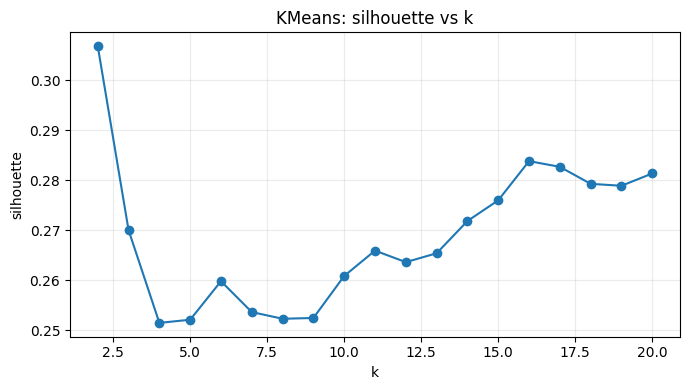

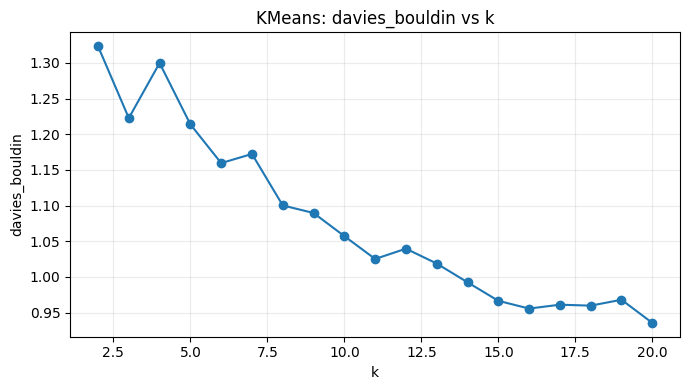

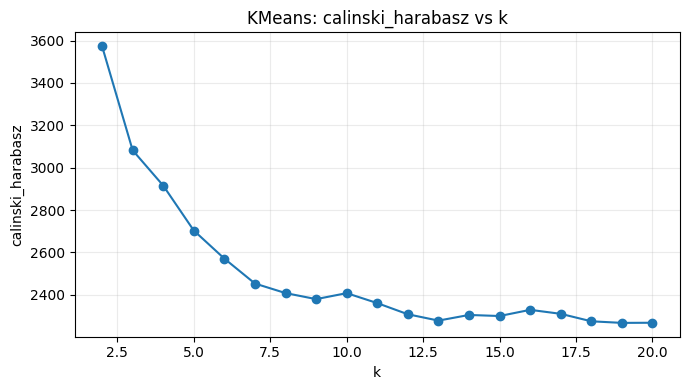

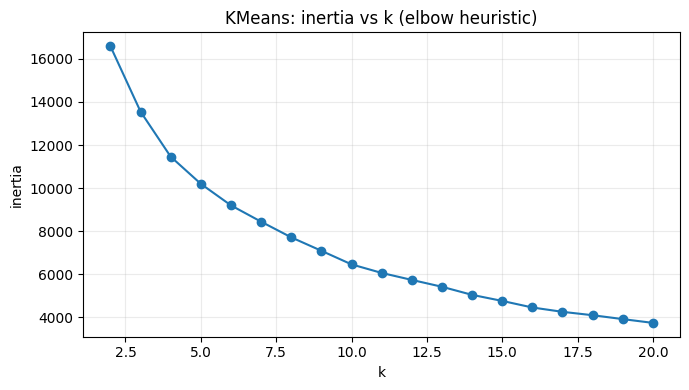

In [19]:
# Построим графики
kmeans_plot_metrics(kmeans_results_02,"silhouette","ds-02")
kmeans_plot_metrics(kmeans_results_02,"davies_bouldin","ds-02")
kmeans_plot_metrics(kmeans_results_02, "calinski_harabasz","ds-02")
kmeans_plot_inertia(kmeans_results_02,"df-02")

In [20]:
# Выберем лучшую модель по силуэту
best_kmeans_02, best_kmeans_s_02 = pick_best(kmeans_results_02,"silhouette")
best_kmeans_02["params"], round(best_kmeans_s_02, 3), best_kmeans_02["metrics"]
 

({'k': 2},
 0.307,
 {'silhouette': 0.3068610017701601,
  'davies_bouldin': 1.3234721699867644,
  'calinski_harabasz': 3573.3933329348392})

#### Метод 2: DBSCAN

In [21]:
# Посчитаем результаты для разных значений min_samples и eps для метода DBSCAN
dbscan_results_02 = eval_dbscan_grid(X_02_scaled,dbscan_eps,dbscan_min_samples)

In [22]:
print(len(dbscan_results_02))
# Посмотрим, какие варианты вообще дали >=2 кластера (без шума) и посчитали silhouette
valid = [r for r in dbscan_results_02 if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid))

# Сортировка по silhouette
valid_sorted_02 = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted_02[:8]:
    print(r["params"], 
          "sil=", round(r["metrics"]["silhouette"], 3),
          "dav_boul=", round(r["metrics"]["davies_bouldin"], 3),
          "cal_har=", round(r["metrics"]["calinski_harabasz"], 3),
           "noise=", round(r["noise_frac"], 3),
             "clusters=", r["n_clusters"])

best_dbscan_02 = valid_sorted_02[0] if valid_sorted_02 else None
print("Лучшие параметры: ",best_dbscan_02["params"] if best_dbscan_02 else "No valid config found")
print("Доля шума в лучшем варианте: ",best_dbscan_02["noise_frac"] if best_dbscan_02 else "No valid config found")

21
Valid DBSCAN configs: 4
{'eps': 0.8, 'min_samples': 10} sil= 0.414 dav_boul= 0.6 cal_har= 48.119 noise= 0.012 clusters= 2
{'eps': 0.5, 'min_samples': 10} sil= 0.251 dav_boul= 0.742 cal_har= 26.169 noise= 0.064 clusters= 2
{'eps': 0.5, 'min_samples': 5} sil= -0.058 dav_boul= 0.79 cal_har= 49.822 noise= 0.045 clusters= 14
{'eps': 0.5, 'min_samples': 3} sil= -0.063 dav_boul= 0.821 cal_har= 40.084 noise= 0.025 clusters= 32
Лучшие параметры:  {'eps': 0.8, 'min_samples': 10}
Доля шума в лучшем варианте:  0.01175


In [23]:
agg_results_02 = eval_agglomerative_grid(X_02_scaled, agg_ks, agg_linkages)
len(agg_results_02), agg_results_02[0]["params"]

(57, {'k': 2, 'linkage': 'ward'})

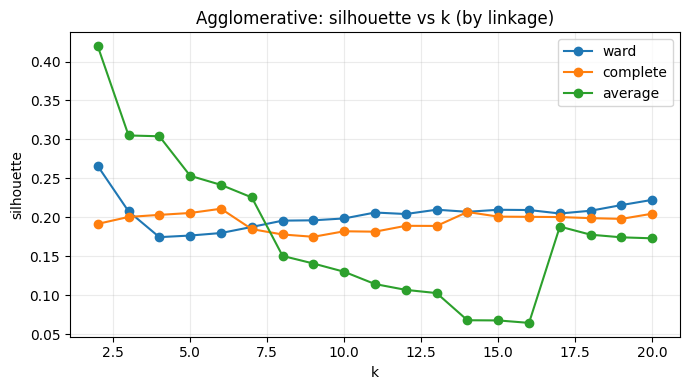

({'k': 2, 'linkage': 'average'},
 0.42,
 {'silhouette': 0.41976775922231674,
  'davies_bouldin': 0.8791287795996852,
  'calinski_harabasz': 395.4825694831712})

In [24]:
# Силуэт по k для разных linkage (на одном графике – удобно для сравнения)
plt.figure(figsize=(7, 4))

for linkage_name in agg_linkages:
    subset = [r for r in agg_results_02 if r["params"]["linkage"] == linkage_name]
    subset = sorted(subset, key=lambda r: r["params"]["k"])
    ks = [r["params"]["k"] for r in subset]
    sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in subset]
    plt.plot(ks, sil, marker="o", label=linkage_name)

plt.title("Agglomerative: silhouette vs k (by linkage)")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / "figures/ds-02_agglo_silVSk(by_linkage).png")
plt.show()

best_agg_02, best_agg_s_02 = pick_best(agg_results_02,"silhouette")
best_agg_02["params"], round(best_agg_s_02, 3), best_agg_02["metrics"]

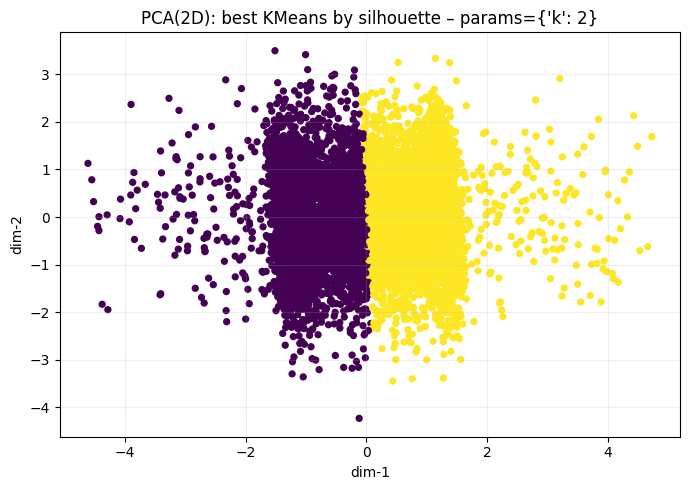

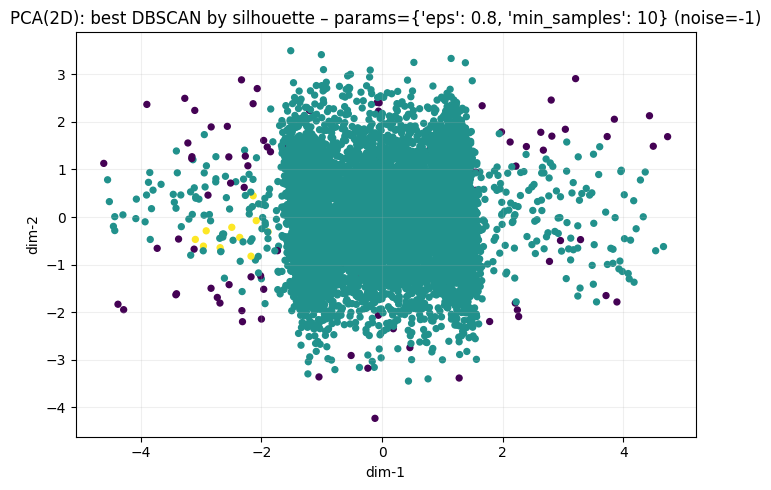

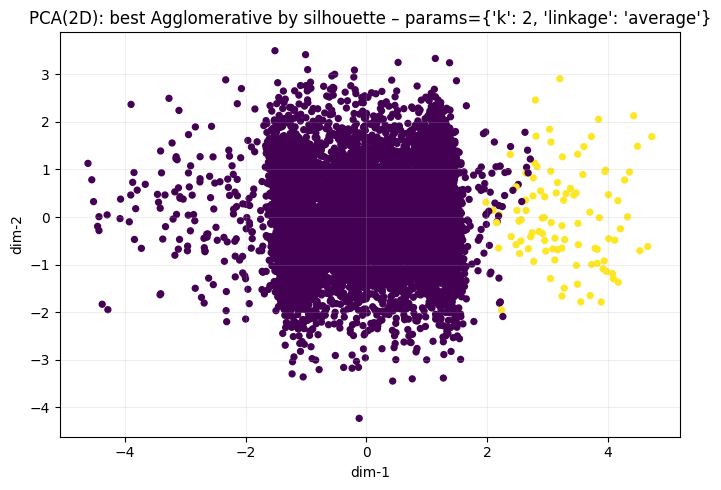

In [25]:
X_plot2d_02 = pca_2d_for_plot(X_02_scaled, random_state=RANDOM_STATE)

# KMeans best
plot_2d_embedding(
    X_plot2d_02, best_kmeans_02["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans_02['params']}",
    file_name="ds-02_kmeans_PCA(2D)"
)

# DBSCAN best (if exists)
if best_dbscan_02 is not None:
    plot_2d_embedding(
        X_plot2d_02, best_dbscan_02["labels"],
        title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan_02['params']} (noise=-1)",
        file_name="ds-02_dbscan_PCA(2D)"
    )

# Agglomerative best
plot_2d_embedding(
    X_plot2d_02, best_agg_02["labels"],
    title=f"PCA(2D): best Agglomerative by silhouette – params={best_agg_02['params']}",
    file_name="ds-02_agglo_PCA(2D)"
)

#### Итог
----
Agglomerative метод продемонстрировал чуть лучшее значение silhouette_score, чем Kmeans, но все еще не очень высокое.
DBSCAN в большинстве конфигураций выявлял один плотный кластер с небольшим числом выбросов, что указывает на отсутствие выраженных плотностных разрывов.
AgglomerativeClustering также склонялся к одному доминирующему кластеру.
KMeans формально показал сопоставимое значение silhouette, однако визуализация через PCA показывает, что разбиение происходит преимущественно вдоль направления максимальной дисперсии, а не вследствие явной кластерной структуры.
Это подтверждает, что данные содержат значительное перекрытие и шум, и задача кластеризации является нетривиальной.

Лучшим будем считать метод agglomerative: k = 2; linkage = average
Метрики:  
'silhouette': 0.41976775922231674,  
'davies_bouldin': 0.8791287795996852,  
'calinski_harabasz': 395.4825694831712  

In [ ]:
# Сохраним результаты
metrics_summery.append({"dataset":"S07-hw-dataset-02.csv","kmeans_results":kmeans_results_02,"dbscan_results":dbscan_results_02,"agg_results":agg_results_02})
best_configs.append({"dataset":"S07-hw-dataset-02.csv","method":best_agg_02["algo"],"parametrs":best_agg_02["params"],"criteria":"silhouette_score"})
labels_hw07_ds2 = pd.DataFrame({
    'sample_id': sample_id_02.values,
    'cluster_label': best_agg_02["labels"]      
})
labels_hw07_ds2.to_csv(ARTIFACTS_DIR / "labels/labels_hw07_ds2.csv")

### Датасет 03

#### Метод 1: Kmeans

In [27]:
# Посчитаем результаты для разных значений k для метода kmeans
kmeans_results_03 = eval_kmeans_grid(X_03_scaled,kmeans_ks)


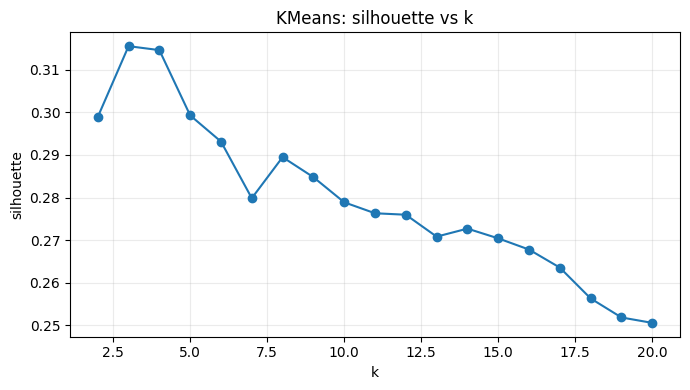

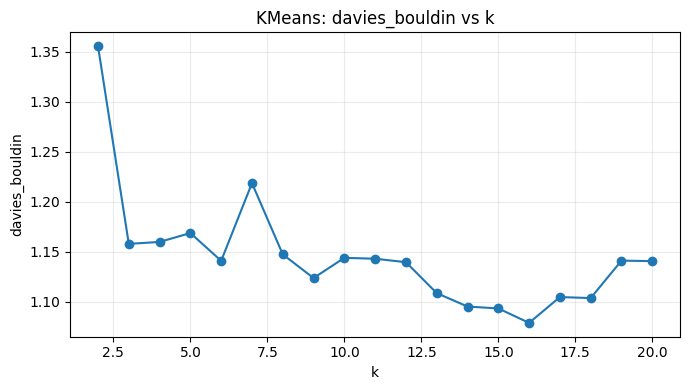

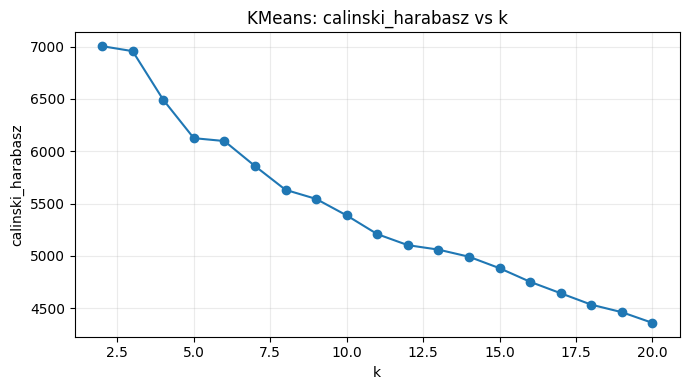

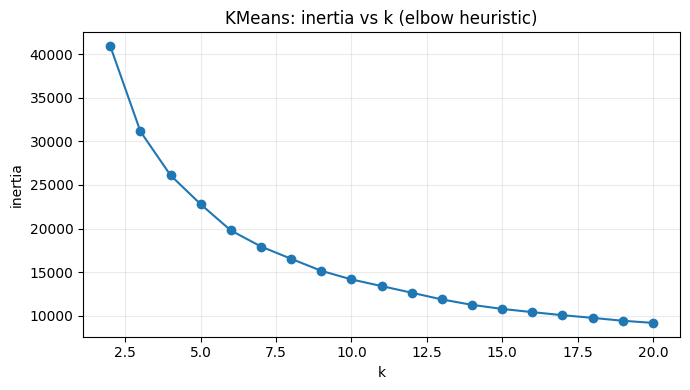

In [28]:
# Построим графики
kmeans_plot_metrics(kmeans_results_03,"silhouette","ds-03")
kmeans_plot_metrics(kmeans_results_03,"davies_bouldin","ds-03")
kmeans_plot_metrics(kmeans_results_03, "calinski_harabasz","ds-03")
kmeans_plot_inertia(kmeans_results_03,"df-03")

In [29]:
# Выберем лучшую модель по силуэту
best_kmeans_03, best_kmeans_s_03 = pick_best(kmeans_results_03,"silhouette")
best_kmeans_03["params"], round(best_kmeans_s_03, 3), best_kmeans_03["metrics"]

 

({'k': 3},
 0.316,
 {'silhouette': 0.31554470037825183,
  'davies_bouldin': 1.1577256320598661,
  'calinski_harabasz': 6957.162639510166})

#### Метод 2: DBSCAN

In [30]:
# Посчитаем результаты для разных значений min_samples и eps для метода DBSCAN
dbscan_results_03 = eval_dbscan_grid(X_03_scaled,dbscan_eps,dbscan_min_samples)

In [31]:
print(len(dbscan_results_03))
# Посмотрим, какие варианты вообще дали >=2 кластера (без шума) и посчитали silhouette
valid = [r for r in dbscan_results_03 if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid))

# Сортировка по silhouette
valid_sorted_03 = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted_03[:8]:
    print(r["params"], 
          "sil=", round(r["metrics"]["silhouette"], 3),
          "dav_boul=", round(r["metrics"]["davies_bouldin"], 3),
          "cal_har=", round(r["metrics"]["calinski_harabasz"], 3),
           "noise=", round(r["noise_frac"], 3),
             "clusters=", r["n_clusters"])

best_dbscan_03 = valid_sorted_03[0] if valid_sorted_03 else None
print("Лучшие параметры: ",best_dbscan_03["params"] if best_dbscan_03 else "No valid config found")
print("Доля шума в лучшем варианте: ",best_dbscan_03["noise_frac"] if best_dbscan_03 else "No valid config found")

21
Valid DBSCAN configs: 4
{'eps': 0.8, 'min_samples': 3} sil= 0.373 dav_boul= 0.551 cal_har= 17.197 noise= 0.001 clusters= 2
{'eps': 0.5, 'min_samples': 10} sil= 0.142 dav_boul= 1.393 cal_har= 1640.791 noise= 0.032 clusters= 2
{'eps': 0.5, 'min_samples': 5} sil= -0.104 dav_boul= 0.842 cal_har= 12.756 noise= 0.022 clusters= 4
{'eps': 0.5, 'min_samples': 3} sil= -0.232 dav_boul= 0.766 cal_har= 10.074 noise= 0.016 clusters= 12
Лучшие параметры:  {'eps': 0.8, 'min_samples': 3}
Доля шума в лучшем варианте:  0.0014666666666666667


In [32]:
agg_results_03 = eval_agglomerative_grid(X_03_scaled, agg_ks, agg_linkages)
len(agg_results_03), agg_results_03[0]["params"]

(57, {'k': 2, 'linkage': 'ward'})

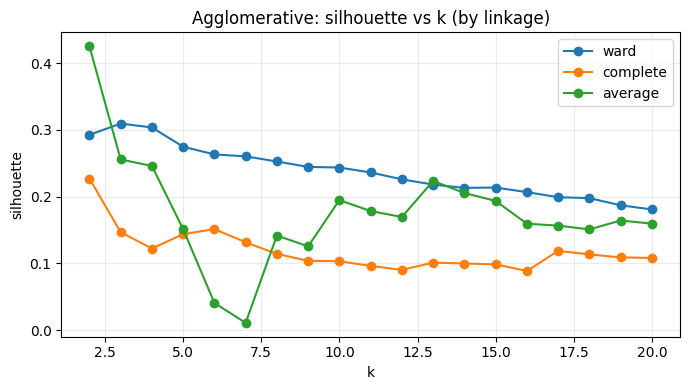

({'k': 2, 'linkage': 'average'},
 0.425,
 {'silhouette': 0.4252961244445327,
  'davies_bouldin': 0.813802016581118,
  'calinski_harabasz': 8.943143115556799})

In [33]:
# Силуэт по k для разных linkage (на одном графике – удобно для сравнения)
plt.figure(figsize=(7, 4))

for linkage_name in agg_linkages:
    subset = [r for r in agg_results_03 if r["params"]["linkage"] == linkage_name]
    subset = sorted(subset, key=lambda r: r["params"]["k"])
    ks = [r["params"]["k"] for r in subset]
    sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in subset]
    plt.plot(ks, sil, marker="o", label=linkage_name)

plt.title("Agglomerative: silhouette vs k (by linkage)")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.legend()
plt.savefig(ARTIFACTS_DIR / "figures/ds-03_agglo_silVSk(by_linkage).png")
plt.tight_layout()
plt.show()

best_agg_03, best_agg_s_03 = pick_best(agg_results_03,"silhouette")
best_agg_03["params"], round(best_agg_s_03, 3), best_agg_03["metrics"]

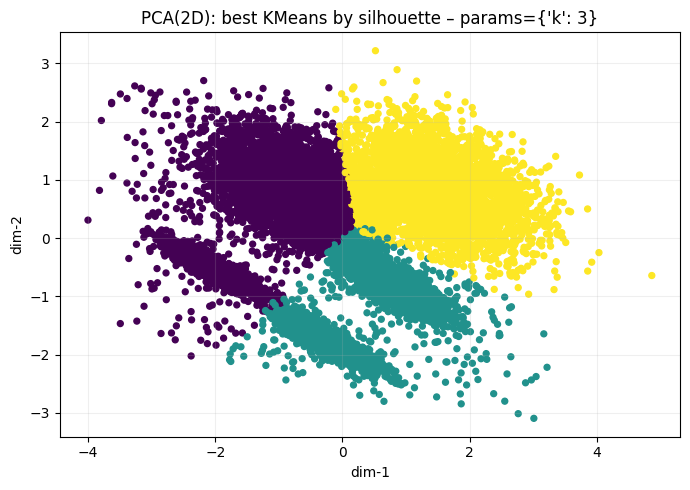

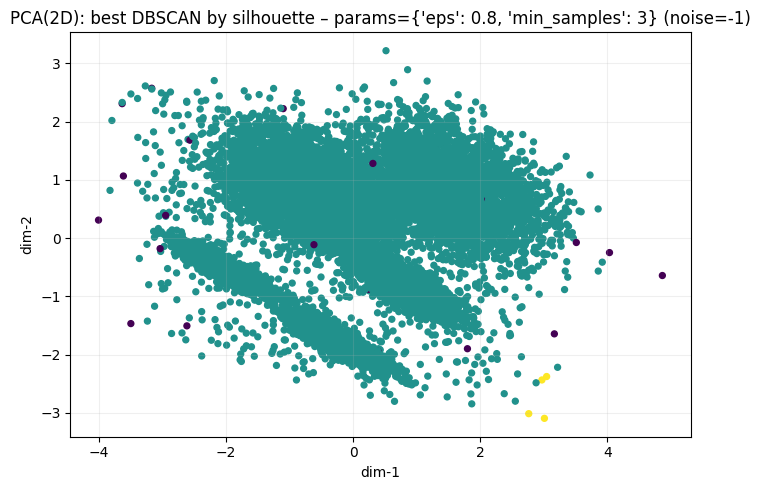

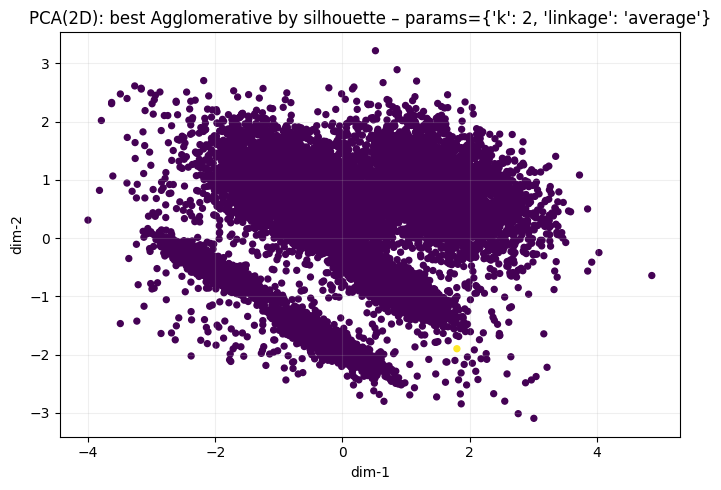

In [34]:
X_plot2d_03 = pca_2d_for_plot(X_03_scaled, random_state=RANDOM_STATE)

# KMeans best
plot_2d_embedding(
    X_plot2d_03, best_kmeans_03["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans_03['params']}",
    file_name="ds-03_kmeans_PCA(2D)"
)

# DBSCAN best (if exists)
if best_dbscan_03 is not None:
    plot_2d_embedding(
        X_plot2d_03, best_dbscan_03["labels"],
        title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan_03['params']} (noise=-1)",
        file_name="ds-03_dbscan_PCA(2D)"
    )

# Agglomerative best
plot_2d_embedding(
    X_plot2d_03, best_agg_03["labels"],
    title=f"PCA(2D): best Agglomerative by silhouette – params={best_agg_03['params']}",
    file_name="ds-03_agglo_PCA(2D)"
)

#### Итог
----
Для данного датасета все рассмотренные алгоритмы продемонстрировали ограничения.   
AgglomerativeClustering показал наибольшее значение silhouette, однако соответствующее разбиение является тривиальным (один доминирующий кластер и небольшой вторичный), что снижает его интерпретируемость.   
KMeans обеспечивает более равномерное разбиение данных и наглядную визуализацию, однако страдает от предположения о равной плотности кластеров, что отражается в более низком значении silhouette.   
DBSCAN оказался чувствительным к выбору параметра eps и при разных настройках либо объединял большую часть точек в один кластер, либо выделял значительное число выбросов.   
В совокупности это подтверждает, что данные обладают разной плотностью и значительным шумом, что затрудняет применение стандартных алгоритмов кластеризации.   
Модель Kmeans можно взять как baseline, а Agglomerative как лучшую, хоть и плохо интерпретируемую

Лучшим будем считать метод agglomerative: k = 2; linkage = average   
Метрики:    
'silhouette': 0.4252961244445327,   
'davies_bouldin': 0.813802016581118,   
'calinski_harabasz': 8.943143115556799   

In [ ]:
# Сохраним результаты
metrics_summery.append({"dataset":"S07-hw-dataset-03.csv","kmeans_results":kmeans_results_03,"dbscan_results":dbscan_results_03,"agg_results":agg_results_03})
best_configs.append({"dataset":"S07-hw-dataset-03.csv","method":best_agg_03["algo"],"parametrs":best_agg_03["params"],"criteria":"silhouette_score"})
labels_hw07_ds3 = pd.DataFrame({
    'sample_id': sample_id_03.values,
    'cluster_label': best_agg_03["labels"]      
})
labels_hw07_ds3.to_csv(ARTIFACTS_DIR / "labels/labels_hw07_ds3.csv")

### Сохранение результатов

In [36]:
# Сохранение сводок метрик и лучшей модели
def save_json(obj, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

import copy
metrics_summery_copy=copy.deepcopy(metrics_summery)
for sum in metrics_summery_copy:
    if 'kmeans_results' in sum:
            for res in sum["kmeans_results"]:
                  if 'labels' in res:
                        del res['labels']
    if 'dbscan_results' in sum:
            for res in sum["dbscan_results"]:
                  if 'labels' in res:
                        del res['labels']
    if 'agg_results' in sum:
            for res in sum["agg_results"]:
                  if 'labels' in res:
                        del res['labels']

save_json(metrics_summery_copy, ARTIFACTS_DIR / "metrics_summary.json")
save_json(best_configs,ARTIFACTS_DIR / "best_configs.json")

print("Saved:", ARTIFACTS_DIR / "best_model_meta.json")

Saved: artifacts\best_model_meta.json
